In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.gaussian_process as gp
from scipy.stats import multivariate_normal
from matplotlib import cm
from scipy.stats import norm
from scipy.special import erf
from scipy.optimize import minimize
from scipy.special import logsumexp

## MC Integration

In [2]:
def f(x):
    return (np.e)**x -4*x**2 + x**3 + 1

true_value = 1.634948495125712
n = 1000
#Normal MC
x1 = np.random.uniform(0,1,n)
mc = np.mean(f(x1))
error1 = np.abs(true_value - mc)
StDev1 = np.sqrt(np.var(f(x1))/n)

#MC with Antithetic Variables
x2 = 1 - x1
mc_at = 0.5*np.mean(f(x1)) + 0.5*np.mean(f(x2))
error2 = np.abs(true_value - mc_at)
StDev2 = np.sqrt(np.var(0.5*f(x1) + 0.5*f(x2))/n)

print(f"True value: {true_value}")
print()
print("Normal Monte Carlo:")
print(f"Value: {mc:.6f}, Absolute Error: {error1:.6f}, StDev:{StDev1:.6f}")
print()
print("Monte Carlo with Antithetic Variables:")
print(f"Value: {mc_at:.6f}, Absolute Error: {error2:.6f}, StDev:{StDev2:.6f}")

True value: 1.634948495125712

Normal Monte Carlo:
Value: 1.629413, Absolute Error: 0.005535, StDev:0.013319

Monte Carlo with Antithetic Variables:
Value: 1.641328, Absolute Error: 0.006380, StDev:0.003926


## Gaussian Process

<div class="alert alert-block alert-info">

The partitioned Gaussian vector:
$$
\begin{bmatrix} \mathbf{x}_1 \\ \mathbf{x}_2 \end{bmatrix} \sim \mathcal{N}\left( \begin{bmatrix} \boldsymbol{\mu}_1 \\ \boldsymbol{\mu}_2 \end{bmatrix}, \begin{bmatrix} \Sigma_{11} & \Sigma_{12} \\ \Sigma_{21} & \Sigma_{22} \end{bmatrix} \right),
$$

$$
\boldsymbol{\mu}_{2|1} = \boldsymbol{\mu}_2 + \Sigma_{21} \Sigma_{11}^{-1} (\mathbf{x}_1 - \boldsymbol{\mu}_1),
$$
$$
\Sigma_{2|1} = \Sigma_{22} - \Sigma_{21} \Sigma_{11}^{-1} \Sigma_{12}.
$$


Let:
$$
\mathbf{x}_1 = \mathbf{f}, \quad \mathbf{x}_2 = \mathbf{f}_*, \quad \boldsymbol{\mu}_1 = \mathbf{0}, \quad \boldsymbol{\mu}_2 = \mathbf{0},
$$
$$
\Sigma_{11} = K(X, X), \quad \Sigma_{12} = K(X, X_*), \quad \Sigma_{21} = K(X_*, X), \quad \Sigma_{22} = K(X_*, X_*).
$$

Then:
$$
p\left( \begin{bmatrix} \mathbf{f} \\ \mathbf{f}_* \end{bmatrix} \middle| X, X_* \right) = \mathcal{N}\left( \begin{bmatrix} \mathbf{0} \\ \mathbf{0} \end{bmatrix}, \begin{bmatrix} K(X, X) & K(X, X_*) \\ K(X_*, X) & K(X_*, X_*) \end{bmatrix} \right),
$$

---

The posterior $\textbf{mean}$ is:
$$
\begin{aligned}
\boldsymbol{\mu}_{\mathbf{f}_* | \mathbf{f}} &= \boldsymbol{\mu}_2 + \Sigma_{21} \Sigma_{11}^{-1} (\mathbf{x}_1 - \boldsymbol{\mu}_1)\\ &= K(X_*, X) K(X, X)^{-1} \mathbf{f}.
\end{aligned}
$$

The posterior $\textbf{covariance}$ is:
$$
\begin{aligned}
\Sigma_{\mathbf{f}_* | \mathbf{f}} &= \Sigma_{22} - \Sigma_{21} \Sigma_{11}^{-1} \Sigma_{12}\\ &= K(X_*, X_*) - K(X_*, X) K(X, X)^{-1} K(X, X_*).
\end{aligned}
$$
  
</div>

#### 1D Gaussian Process

In [3]:
def gp_predict1d(xs,ys,x_eval,kernel, s=1, l=1):
    
    x_eval = x_eval.reshape(-1,1)
    ys = ys.reshape(-1,1)
    
    K_xx = kernel(xs, xs, s, l)
    K_xs = kernel(x_eval, xs, s, l)
    K_sx = kernel(xs, x_eval, s, l)
    K_xx_eval = kernel(x_eval, x_eval, s, l)

    mu = K_xs @ np.linalg.solve(K_xx, ys)
    sig = K_xx_eval - K_xs @ np.linalg.solve(K_xx, K_sx)

    return mu.ravel(), sig + 1e-9*np.eye(sig.shape[0])

#Kernel 1
def rbf1d(x1,x2,s=10, l=0.2):
    x1 = x1.reshape(-1,1)
    x2 = x2.reshape(1,-1)
    dists = (x1-x2)**2/(2*l**2)
    return s**2*np.exp(-dists)

#Kernel 2
def matern1d(x1,x2,rho=1/5):
    x1 = x1.reshape(-1,1)
    x2 = x2.reshape(1,-1)
    return (1. + np.sqrt(3.)*np.abs(x1-x2)/rho)*np.exp(-np.sqrt(3.)*np.abs(x1-x2)/rho)


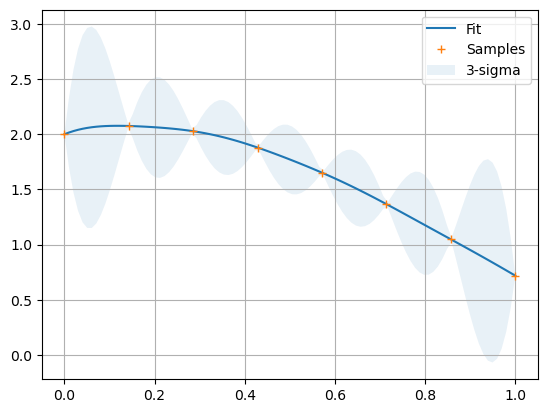

In [4]:
x = np.linspace(0,1,8)
y = f(x)
s = 10
l = 0.2

x_eval = np.linspace(0,1,100)
mu_eval,var_eval = gp_predict1d(x,y,x_eval,kernel=rbf1d, s=s, l=l)
sig_diag = np.sqrt(np.diag(var_eval))

plt.plot(x_eval,mu_eval,label='Fit')
plt.plot(x,y,'+',label='Samples')
plt.fill_between(x_eval,mu_eval-3*sig_diag,mu_eval+3*sig_diag,alpha=0.1,label='3-sigma')
plt.legend()
plt.grid()
plt.show()

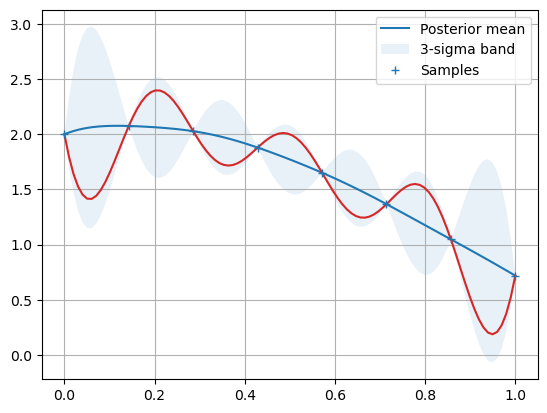

In [5]:
#sample paths of the GP posterior
n_samples = 100000
samples = np.random.multivariate_normal(mu_eval, var_eval, size=n_samples)

#use trapezoidal rule weights for integration
dx = np.diff(x_eval)
weights = np.zeros_like(x_eval)
weights[1:-1] = (dx[:-1] + dx[1:])/2
weights[0] = dx[0]/2
weights[-1] = dx[-1]/2

#compute integrals and find 1% with lowest values
integrals = samples@weights
n_bottom = int(0.01*n_samples)
bottom_idx = np.argsort(integrals)[:n_bottom]
bottom_mean_curve = samples[bottom_idx].mean(axis=0)

#plot results
plt.plot(x_eval, mu_eval, label='Posterior mean', color='C0')
std_eval = np.sqrt(np.diag(var_eval))
plt.fill_between(
    x_eval,
    mu_eval - 3 * std_eval,
    mu_eval + 3 * std_eval,
    alpha=0.1,
    label='3-sigma band'
)
plt.plot(x_eval, bottom_mean_curve, color='C3')
plt.plot(x,y,'+',label='Samples')
plt.legend()
plt.grid()
plt.show()



#### 2D Gaussian Process

In [6]:
def gp_predict2d(xs, ys, x_eval, kernel, l = 5, s = 5):

    ys = ys.reshape(-1,1)

    K = kernel(xs, xs, l, s) + 1e-6*np.eye(xs.shape[0])
    K_s = kernel(xs, x_eval, l, s)
    K_ss = kernel(x_eval, x_eval, l, s)

    # Solve for alpha
    alpha = np.linalg.solve(K, ys)

    # Predictive mean
    mu = K_s.T @ alpha

    # Predictive covariance
    v = np.linalg.solve(K, K_s)
    sig = K_ss - K_s.T @ v

    return mu.ravel(), sig


def rbf2d(X1, X2, l=2, s=1):
    X1 = np.atleast_2d(X1)
    X2 = np.atleast_2d(X2)

    diff = X1[:, None, :] - X2[None, :, :]
    sqdist = np.sum(diff**2, axis=2)
    return s**2*np.exp(-0.5/l**2*sqdist)

1. **Saturation vapour pressure over water:**

$$
e_s(T) = 6.1121 \, \exp\left(\left(18.678 - \frac{T}{234.5}\right) \cdot \left(\frac{T}{257.14 + T}\right)\right)
$$

2. **Actual vapour pressure from dew point:**

$$
e = 6.1121 \, \exp\left(\left(18.678 - \frac{T_d}{234.5}\right) \cdot \left(\frac{T_d}{257.14 + T_d}\right)\right)
$$

3. **Relative Humidity:**

$$
RH = 100 \times \frac{e}{e_s(T)}
$$

In [7]:
def RH(T, Td):
    eT = 6.1121*np.exp((18.678 - T/234.5)*(T/(257.14 + T)))
    eTd = 6.1121*np.exp((18.678 - Td/234.5)*(Td/(257.14 + Td)))
    return 100*eTd/eT

For Temp: 19.6°C and DewP: 19.6°C
-----------------------------------------------------------------
Relative humidity is: 99.8894%
The gp estimate is: 99.1297%
Error: 0.7597
95% CI: [98.9687%, 99.2907%]

The estimate does not fall within the bounds


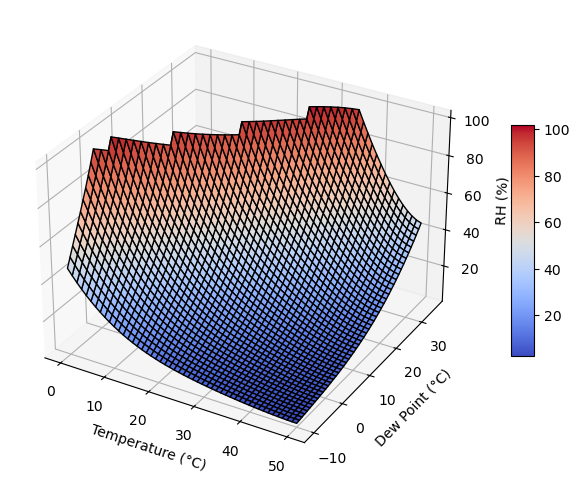

In [8]:
Temp = np.linspace(0,50,5)
DewP = np.linspace(-10,35,4)
T, D = np.meshgrid(Temp, DewP)
TD = np.column_stack([T.ravel(), D.ravel()])
rh = RH(TD[:,0], TD[:,1])

Temp_eval = np.linspace(0,50,50)
DewP_eval = np.linspace(-10,35,50)
T_eval, D_eval = np.meshgrid(Temp_eval, DewP_eval)
TD_eval = np.column_stack([T_eval.ravel(), D_eval.ravel()])

l = 120
s = 27000
mu_grid, var_grid = gp_predict2d(TD, rh, TD_eval, kernel=rbf2d, l=l, s=s)
mu_grid = mu_grid.reshape(T_eval.shape)
mu_grid = np.where(D_eval > T_eval, np.nan, mu_grid)


T = np.random.uniform(0,50,1)[0]
D = np.random.uniform(-10,T,1)[0]
relhum = RH(T,D)

gp_est, gp_var = gp_predict2d(TD, rh, (T,D), kernel=rbf2d, l=l, s=s)
low = gp_est - 1.96*np.sqrt(gp_var)
high = gp_est + 1.96*np.sqrt(gp_var)
error = np.abs(relhum - gp_est)

print(f'For Temp: {T:.1f}°C and DewP: {D:.1f}°C')
print('-----------------------------------------------------------------')
print(f'Relative humidity is: {relhum:.4f}%')
print(f'The gp estimate is: {gp_est[0]:.4f}%')
print(f'Error: {error[0]:.4f}')
print(f'95% CI: [{low[0][0]:.4f}%, {high[0][0]:.4f}%]')
print()

print(f'The estimate does{str(np.where((relhum<low or relhum>high), " not ", " " )[0][0])}fall within the bounds')

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(T_eval, D_eval, mu_grid, cmap=cm.coolwarm, edgecolor='k')
ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('Dew Point (°C)')
ax.set_zlabel('RH (%)')
fig.colorbar(surf, shrink=0.5, aspect=10)
plt.show()


In [9]:
n = 3000
T = np.random.uniform(0,50,n)
D = np.random.uniform(-10,T,n)
relhum = RH(T,D)

TD_eval = np.column_stack([T.ravel(), D.ravel()])

l = 110
s = 27000
gp_est, gp_var = gp_predict2d(TD, rh, TD_eval, kernel=rbf2d, l=l, s=s)


low = gp_est - 1.96*np.sqrt(np.diag(gp_var))
high = gp_est + 1.96*np.sqrt(np.diag(gp_var))


inbounds = np.mean(np.array(low<relhum) == np.array(relhum<high))
error = np.mean(np.abs(relhum - gp_est))

print(f'In bounds: {inbounds}')
print(f'Error: {error}')


In bounds: 0.8113333333333334
Error: 1.1754112939701113


## Bayesian Quadrature

$$
F(x) := \int_a^x f(t)\,dt
$$

where $f \sim \mathcal{GP}(m(x), k(x, x'))$,

---

Mean function:

$$
\mathbb{E}[F(x)] = \mathbb{E}\left[\int_a^x f(t) dt\right] = \int_a^x \mathbb{E}[f(t)] dt = \int_a^x m(t)\,dt
$$


$$
M(x) = \int_a^x m(t) dt
$$

Covariance function:


$$
K(x, x') := \operatorname{Cov}(F(x), F(x')) = \operatorname{Cov} \left( \int_a^x f(t) dt,\ \int_a^{x'} f(s) ds \right)
$$

Using Fubini's Theorem:
$$
K(x, x') = \int_a^x \int_a^{x'} \operatorname{Cov}(f(t), f(s))\, ds\, dt
= \int_a^x \int_a^{x'} k(t, s)\, ds\, dt
$$


$$
K(x, x') = \iint_{[a,x]\times[a,x']} k(t, s)\, dt\, ds
$$

---

$$
F(x) \sim \mathcal{GP}\left( M(x),\ K(x, x') \right)
$$

where:

* $M(x) = \int_a^x m(t)\,dt$
* $K(x, x') =  \int_a^x \int_a^{x'} k(t, s)\,ds\,dt$


$$
E[F|y] = M(x) + \textbf{k}_F^T K^{-1} \left( y-m(X) \right)
$$

$$
Var(F|y) = K(x,x) - \textbf{k}_F^T K^{-1} \textbf{k}_F
$$


where $\textbf{k}_F = \left( \int_a^x k(t, x_1)dt, \int_a^x k(t, x_2)dt, \cdots , \int_a^x k(t, x_n)dt \right)$

---

Lets start by deriving the mean of the integral

Using RBF Kernel $k(y,x) = \sigma_f^2\exp \left(-\frac{1}{2l^2} |x-y|^2 \right)$:
$$
\begin{aligned}
v[k] &= \int_a^x k(t,s) dt \\
     &= \int_a^x \sigma_f^2\exp \left(-\frac{1}{2l^2} |s-t|^2 \right) dt \\
\end{aligned}
$$
Let $l = \sigma$ hereon and factor out $\sigma_f^2 \cdot \sigma \sqrt{2\pi}$:
$$
\begin{aligned}
v[k] &= \sigma_f^2 \cdot \sigma \sqrt{2\pi} \int_a^x \frac{1}{\sigma\sqrt{2\pi}}\exp \left(-\frac{(s-t)^2}{2\sigma^2} \right) dt \\
     &= \sigma_f^2 \cdot \sigma \sqrt{2\pi} \int_a^x k^*(t,s) dt \\
\end{aligned}
$$
Now working with just $k^*(t,s)$:
$$
\begin{aligned}
v^*[k] &= \int_a^x \frac{1}{\sigma\sqrt{2\pi}}\exp \left(-\frac{(s-t)^2}{2\sigma^2} \right) dt \\
     &= \frac{1}{2} \left[1+\text{erf} \left(\frac{x-s}{\sigma\sqrt{2}} \right) \right] - \frac{1}{2} \left[1+\text{erf} \\ \left(\frac{a-s}{\sigma\sqrt{2}} \right) \right] \\
     &= \frac{1}{2} \left[ \text{erf} \left(\frac{x-s}{\sigma\sqrt{2}} \right) - \text{erf}\left(\frac{a-s}{\sigma\sqrt{2}} \right) \right]
\end{aligned}
$$

---

For the uncertainty we have to integrate again. 

$$
\begin{aligned}
vv[k] &= \int_a^x \int_a^x k(t,s) dsdt \\
      &= \sigma_f^2 \cdot \sigma \sqrt{2\pi} \int_a^x \int_a^x k^*(t,s) dtds \\
      &= \sigma_f^2 \cdot \sigma \sqrt{2\pi} \int_a^x \frac{1}{2}\text{erf} \left(\frac{x-s}{\sigma\sqrt{2}} \right) - \frac{1}{2}\text{erf} \left(\frac{a-s}{\sigma\sqrt{2}} \right)ds \\
\end{aligned}
$$

Focusing on just $k^*(t,s)$, let $u_1 = \frac{x-s}{\sigma\sqrt{2}}$ and $u_2 = \frac{a-s}{\sigma\sqrt{2}}$  

$\implies$ $du_1 = du_2 = du = \frac{-1}{\sigma\sqrt{2}} \cdot ds$ 

$\implies$ $ds = -\sigma\sqrt{2} \cdot du$

$$
\begin{aligned}
vv^*[k] &= \int_a^x \frac{1}{2}\text{erf}(u_1)ds - \int_a^x\frac{1}{2}\text{erf}(u_2)ds \\
       &= \int_{\frac{x-a}{\sigma\sqrt{2}}}^0 -\frac{1}{2}\text{erf}(u_1) \cdot \sigma\sqrt{2} \cdot du_1 - \int_0^{\frac{a-x}{\sigma\sqrt{2}}} - \frac{1}{2}\text{erf}(u_2) \cdot \sigma\sqrt{2} \cdot du_2 \\
       &= \int_0^{\frac{x-a}{\sigma\sqrt{2}}} \frac{1}{2}\text{erf}(u) \cdot \sigma\sqrt{2} \cdot du - \int_{\frac{a-x}{\sigma\sqrt{2}}}^0 \frac{1}{2}\text{erf}(u) \cdot \sigma\sqrt{2} \cdot du \\
       &= \frac{\sigma\sqrt{2}}{2} \left(\int_0^{\frac{x-a}{\sigma\sqrt{2}}} \text{erf}(u)du + \int_0^{\frac{x-a}{\sigma\sqrt{2}}} \text{erf}(u)du \right) \\
       &= \sigma\sqrt{2} \left(\int_0^{\frac{x-a}{\sigma\sqrt{2}}} \text{erf}(u)du \right) \\
\end{aligned}
$$

Using $ \int_0^\theta \text{erf}(u)du = \theta \, \text{erf}(\theta) + \frac{e^{-\theta^2} - 1}{\sqrt{\pi}}$, Let $\theta = \frac{x-a}{\sigma\sqrt{2}}$:

$$
\begin{aligned}
vv^*[k] &= \sigma\sqrt{2} \left(\theta \, \text{erf}(\theta) + \frac{e^{-\theta^2} - 1}{\sqrt{\pi}} \right) \\
        &= (x-a) \, \text{erf} \left( \frac{x-a}{\sigma \sqrt{2}} \right) + \sigma\sqrt{2} \left( \frac{\exp{\left(-{\frac{(x-a)^2}{2 \sigma^2}}\right)} - 1}{\sqrt{\pi}} \right)\\
\end{aligned}
$$

---

So we have:
$$
\begin{align*}
v[k] &= \left( \sigma_f^2 \cdot \sigma \sqrt{2\pi} \right) v^*[k] \\
     &= \left( \sigma_f^2 \cdot \sigma \sqrt{2\pi} \right) \, \left[\frac{1}{2} \text{erf} \left(\frac{x-s}{\sigma\sqrt{2}} \right) - \frac{1}{2} \text{erf}\left(\frac{a-s}{\sigma\sqrt{2}} \right) \right] \\
     \\
vv[k] &= \left( \sigma_f^2 \cdot \sigma \sqrt{2\pi} \right) vv^*[k] \\
      &= \left( \sigma_f^2 \cdot \sigma \sqrt{2\pi} \right) \left[(x-a) \, \text{erf} \left( \frac{x-a}{\sigma \sqrt{2}} \right) + \sigma\sqrt{2} \left( \frac{\exp{\left(-{\frac{(x-a)^2}{2 \sigma^2}}\right)} - 1}{\sqrt{\pi}} \right) \right] \\
      &= \sigma_f^2 \left[ \sigma \sqrt{2\pi} \, (x-a) \, \text{erf} \left( \frac{x-a}{\sigma \sqrt{2}} \right) + 2 \sigma^2 \left( e^{-{\frac{(x-a)^2}{2 \sigma^2}}} - 1 \right) \right] \\
\end{align*}
$$



#### 1D Example

In [10]:
def vk(input,lower, upper, s=1,l=1):
    return s**2*l*np.sqrt(2*np.pi)*(0.5*erf((upper-input)/(l*np.sqrt(2))) - 0.5*erf((lower-input)/(l*np.sqrt(2))))

def vvk(lower, upper, s=1, l=1):
    return s**2*(l*np.sqrt(2*np.pi)*(upper-lower)*erf((upper-lower)/(l*np.sqrt(2))) + 2*l**2*(np.exp(-(upper-lower)**2/(2*l**2)) - 1))

def integrate_rbf1d(x_eval,y_eval, lower, upper, s=1,l=1):
    
    x_eval = x_eval.reshape(-1,1)
    y_eval = y_eval.reshape(-1,1)
    
    kxx = rbf1d(x_eval,x_eval.T,s,l)
    
    mu = vk(x_eval,lower,upper,s,l).reshape(1,-1)@np.linalg.solve(kxx,y_eval)
    var = vvk(lower,upper,s,l) - vk(x_eval,lower,upper,s,l).reshape(1,-1)@np.linalg.solve(kxx,vk(x_eval,lower,upper,s,l).reshape(-1,1))
    
    return mu, var

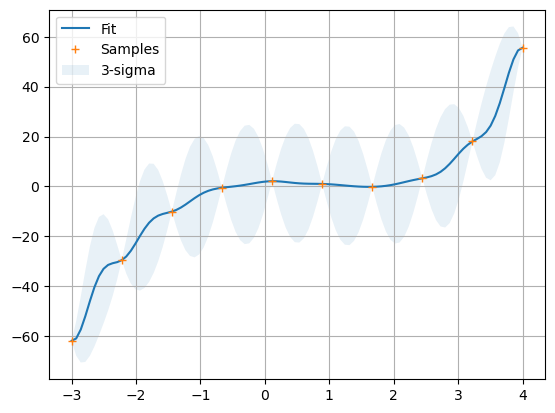

In [11]:
def f(x):
    return (np.e)**x -4*x**2 + x**3 + 1

#integral of f(x) from -3 to 4
true_value = -16.03497036855696

lower = -3
upper = 4
s = 10
l = 0.3
#sample n points
n = 10
x = np.linspace(lower,upper,n)
y = f(x)

#points to plot gp
x_eval = np.linspace(lower,upper,100)
mu_eval,var_eval = gp_predict1d(x,y,x_eval,kernel=rbf1d,s=s,l=l)
sig_diag = np.sqrt(np.diag(var_eval))

#plot gp
plt.plot(x_eval,mu_eval,label='Fit')
plt.plot(x,y,'+',label='Samples')
plt.fill_between(x_eval,mu_eval-3*sig_diag,mu_eval+3*sig_diag,alpha=0.1,label='3-sigma')
plt.legend()
plt.grid()
plt.show()

In [12]:
print(f"True value: {true_value}")
print()
print("Bayesian Quadrature")
for n in [1,3,5,8,12,20,50,75]:
    x = np.linspace(lower,upper,n)
    y = f(x)
    I_mu, I_var = integrate_rbf1d(x,y,lower,upper,s,l)
    error = np.abs(true_value - I_mu[0][0])
    print(f"{n} pts:")
    print(f"Estimate: {I_mu[0][0]:.8f} , StDev: {np.sqrt(I_var[0][0]):.10f}")
    print(f"Absolute Error: {error:.8f}")
    print()

True value: -16.03497036855696

Bayesian Quadrature
1 pts:
Estimate: -23.29292330 , StDev: 22.2318413707
Absolute Error: 7.25795293

3 pts:
Estimate: -1.05452110 , StDev: 20.5807904616
Absolute Error: 14.98044927

5 pts:
Estimate: -5.03123090 , StDev: 17.6202047367
Absolute Error: 11.00373947

8 pts:
Estimate: -10.81723423 , StDev: 11.9802563167
Absolute Error: 5.21773613

12 pts:
Estimate: -15.22298224 , StDev: 4.1389263376
Absolute Error: 0.81198813

20 pts:
Estimate: -15.98816993 , StDev: 0.4337733602
Absolute Error: 0.04680044

50 pts:
Estimate: -16.03446287 , StDev: 0.0017914405
Absolute Error: 0.00050750

75 pts:
Estimate: -16.03496803 , StDev: 0.0000065598
Absolute Error: 0.00000234



## Trivial run of VBMC

In [13]:
def plot_GP_surrogate(X, y, X_new, y_pred_mean, y_pred_std, samples):
    plt.figure(figsize=(10, 6))

    #for i, sample in enumerate(samples):
    #    plt.plot(X_new, sample, lw=2, ls='--', label=f'Sample {i+1}')

    plt.plot(X_new, y_pred_mean, lw=2, color='gray', label='GP Mean')
    plt.fill_between(X_new.ravel(),
                    y_pred_mean.ravel() - 2*y_pred_std.ravel(),
                    y_pred_mean.ravel() + 2*y_pred_std.ravel(),
                    color='lightgray', label='95% CI')


    plt.scatter(X, y, c='red', s=50, label='Observed')
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.title("Log GP Surrogate")
    plt.legend(loc='upper left')
    plt.tight_layout()
    #plt.show()

In [14]:
#aim of vbmc is to find a distribution over the following parameter
parameter = 2.0

#In practice we wont know the the value of the parameter (obviously) and likelihoods will be difficult or expensive
def expensive_log_likelihood(theta):
    return -(parameter - theta)**2

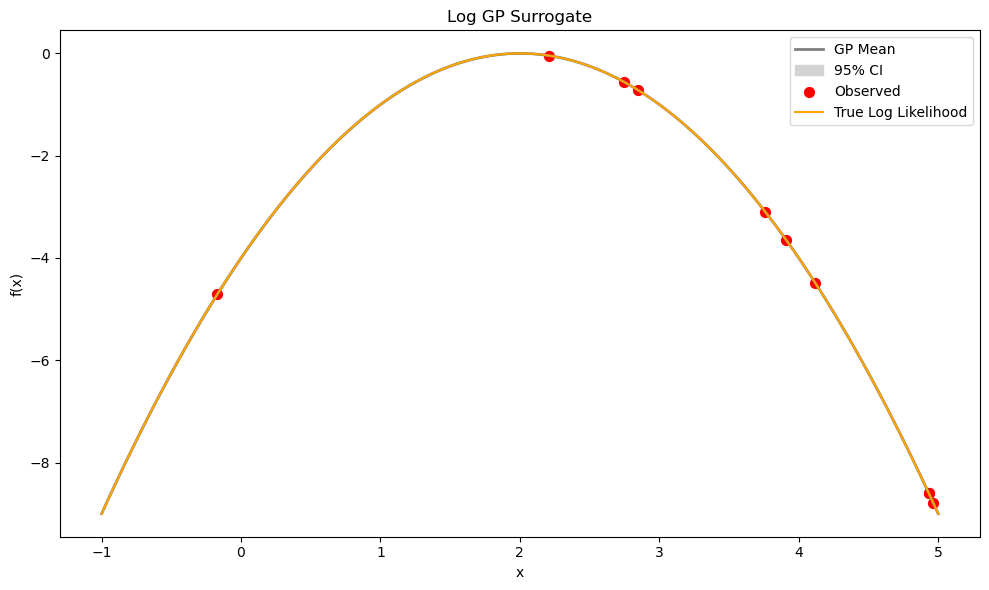

In [15]:
n = 10

#vbmc traditionally samples much smarter than randomly but here we sample 3 random points and infer a likelihood
x = np.sort(np.random.uniform(-1,5,n)).reshape(-1,1)
y = expensive_log_likelihood(x.ravel()).reshape(-1,1)

#hyperparameters for gp
s = 5
l = 10

#plot gp
x_eval= np.linspace(-1,5,100).reshape(-1,1)
mu_eval,var_eval = gp_predict1d(x,y,x_eval,kernel=rbf1d,s=s,l=l)
sig_diag = np.sqrt(np.diag(var_eval))

plot_GP_surrogate(x, y, x_eval, mu_eval, sig_diag, samples=[])


mu = 2
x_vals = np.linspace(-1, 5, 500)
log_likelihood = -(mu - x_vals)**2

plt.plot(x_vals, log_likelihood, label='True Log Likelihood', color='orange')
plt.legend()
plt.show()


### Find variational posterior

$$
\log p(\mathbf{x}) = \underbrace{\mathbb{E}_q[\log p(\mathbf{z},\mathbf{x})] - \mathbb{E}_q[\log q(\mathbf{z})]}_{= ELBO} + \underbrace{\text{KL}(q(\mathbf{z})||p(\mathbf{z}|\mathbf{x}))}_{\ge 0}
$$

$$
ELBO = \underbrace{\mathbb{E}_q[\log p(\mathbf{z},\mathbf{x})]}_{=\text{Expected Log Joint}} + \underbrace{\left(-\mathbb{E}_q[\log q(\mathbf{z})]\right)}_{=\text{Entropy of Q}}
$$

In [16]:
def elbo(params, x, y, s=1, l=1):
    mu, log_s = params
    s = np.exp(log_s)

    #gaussian q
    lower = mu - 5*s
    upper = mu + 5*s

    #expected log-joint using quadrature with integrated GP
    mu_int, var_int = integrate_rbf1d(x, y, lower, upper, s, l)
    expected_log_joint = mu_int

    #entropy of Gaussian q
    entropy_q = 0.5*np.log(2*np.pi*np.e*s**2)

    #negative ELBO
    return -expected_log_joint - entropy_q

initial = [0.0, 0.0]
bounds = [(None, None), (-5, 1)]

res = minimize(elbo,
               initial,
               args=(x, y, s, l),
               method='L-BFGS-B',
               bounds=bounds)

mu, log_s = res.x
s = np.exp(log_s)

print("Optimised mu:", mu)
print("Optimised s:", s)


Optimised mu: 7.105406864796575e-06
Optimised s: 0.999999991262746


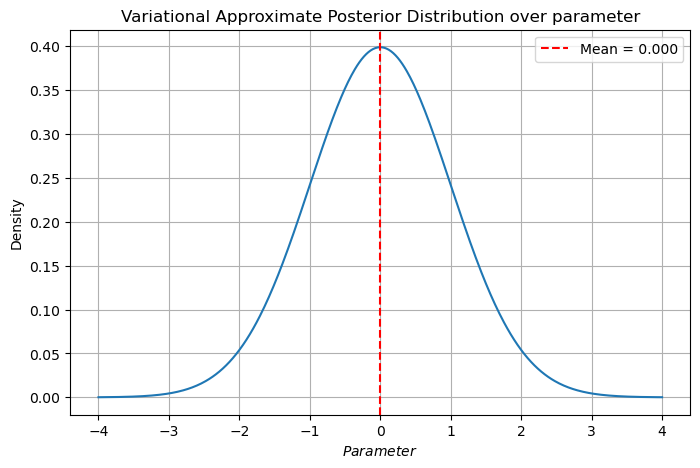

In [17]:
x_vals = np.linspace(mu - 4*s, mu + 4*s, 500)
pdf_vals = norm.pdf(x_vals, loc=mu, scale=s)

plt.figure(figsize=(8,5))
plt.plot(x_vals, pdf_vals)
plt.axvline(mu, color='r', linestyle='--', label=f'Mean = {mu:.3f}')
plt.title('Variational Approximate Posterior Distribution over parameter')
plt.xlabel('$Parameter$')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()